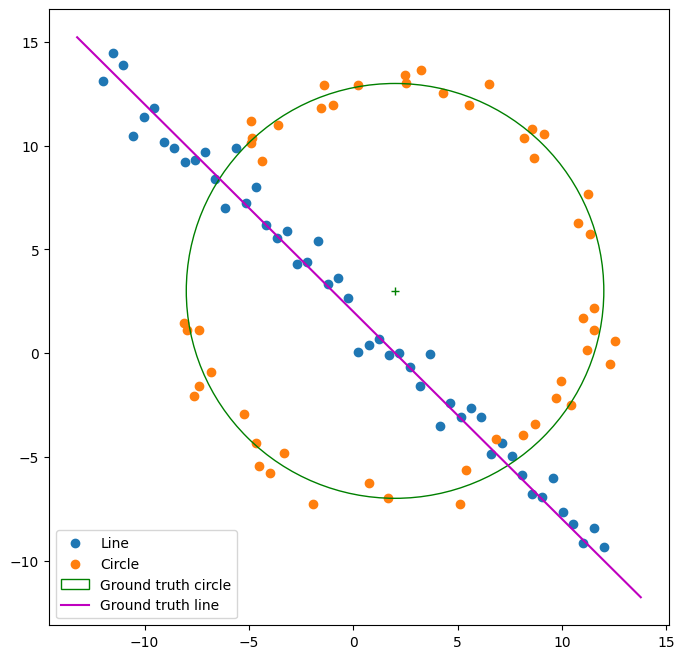

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
#import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2
r_init = 10
x0_gt, y0_gt = 2, 3 # Center
s = r_init / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r_init + n) * np.cos(t), y0_gt + (r_init + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
s = 1.
m_init, b_init = -1, 2
x = np.linspace(-12, 12, half_n)
y = m_init * x + b_init + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1 ,1 , figsize =(8 ,8))
ax.scatter(X_line[:, 0], X_line[:, 1], label = 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label = 'Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = 'g', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = 'g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = 'm', label = 'Ground truth line')
plt.legend()

In [ ]:
# Define a function to calculate the distance between a point and a line
def point_line_distance(point, line_params):
    a, b, d = line_params
    x, y = point
    return abs(a*x + b*y + d) / np.sqrt(a*a + b*b)

# RANSAC parameters for estimating the line
max_iterations_line = 1000
min_inliers_line = 20
inlier_threshold_line = 1.5

best_line_params = None
best_line_inliers = []

for _ in range(max_iterations_line):
    # Randomly sample two points to define a line
    sample_indices_line = np.random.choice(N, 2, replace=False)
    sample_points_line = X[sample_indices_line]

    # Calculate line parameters (a, b, d) using the two points
    x1, y1 = sample_points_line[0]
    x2, y2 = sample_points_line[1]
    a = y2 - y1
    b = x1 - x2
    d = x2*y1 - x1*y2
    norm = np.sqrt(a*a + b*b)
    a /= norm
    b /= norm
    d /= norm

    # Count inliers based on the distance threshold
    inliers = [i for i, point in enumerate(X) if point_line_distance(point, (a, b, d)) < inlier_threshold_line]

    if len(inliers) >= min_inliers_line:
        if len(inliers) > len(best_line_inliers):
            best_line_params = (a, b, d)
            best_line_inliers = inliers


In [ ]:
# Subtract the line inliers from all points to get the remnant points
remnant_points = np.delete(X, best_line_inliers, axis=0)

# Define a function to calculate the distance between a point and a circle
def point_circle_distance(point, circle_params):
    x_center, y_center, r = circle_params
    x, y = point
    return abs(np.sqrt((x - x_center)**2 + (y - y_center)**2) - r)

# RANSAC parameters for estimating the circle
max_iterations_circle = 1000
min_inliers_circle = 15
radial_error_threshold_circle = 1

best_circle_params = None
best_circle_inliers = []

for _ in range(max_iterations_circle):
    # Randomly sample three points to define a circle
    sample_indices_circle = np.random.choice(len(remnant_points), 3, replace=False)
    sample_points_circle = remnant_points[sample_indices_circle]

    # Calculate circle parameters (x_center, y_center, r) using the three points
    x1, y1 = sample_points_circle[0]
    x2, y2 = sample_points_circle[1]
    x3, y3 = sample_points_circle[2]
    D = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    x_center = ((x1**2 + y1**2)*(y2-y3) + (x2**2 + y2**2)*(y3-y1) + (x3**2 + y3**2)*(y1-y2)) / D
    y_center = ((x1**2 + y1**2)*(x3-x2) + (x2**2 + y2**2)*(x1-x3) + (x3**2 + y3**2)*(x2-x1)) / D
    r = np.sqrt((x1-x_center)**2 + (y1-y_center)**2)

    # Count inliers based on the radial error threshold
    inliers = [i for i, point in enumerate(remnant_points) if point_circle_distance(point, (x_center, y_center, r)) < radial_error_threshold_circle]

    if len(inliers) >= min_inliers_circle:
        if len(inliers) > len(best_circle_inliers):
            best_circle_params = (x_center, y_center, r)
            best_circle_inliers = inliers


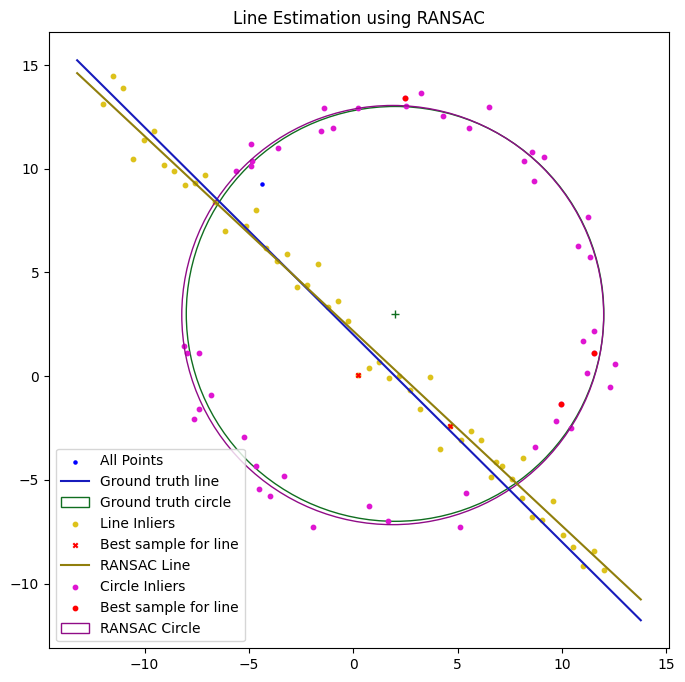

In [ ]:
# Plot the line and inliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='b', s=5)

# Ground truth line
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = '#171BBC', label = 'Ground truth line')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = '#106E20', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = '#106E20')

# Line inliers
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Line Inliers', color='#DDC21B', s=10)

# Best sample for line
ax.scatter(X[sample_indices_line, 0], X[sample_indices_line, 1], label='Best sample for line', color='r', s=10, marker = 'x')

# RANSAC line
x_range = np.linspace(x_min, x_max, 100)
y_range = (-best_line_params[0] * x_range - best_line_params[2]) / best_line_params[1]
plt.plot(x_range, y_range, color='#907E0C', label='RANSAC Line')

# Circle inliers
ax.scatter(remnant_points[best_circle_inliers, 0], remnant_points[best_circle_inliers, 1], label='Circle Inliers', color='#DF15D1', s=10)

# Best sample for circle
ax.scatter(X[sample_indices_circle, 0], X[sample_indices_circle, 1], label='Best sample for line', color='r', s=10)

# RANSAC circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='#900C87', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

plt.legend()
plt.title('Line Estimation using RANSAC')
plt.show()

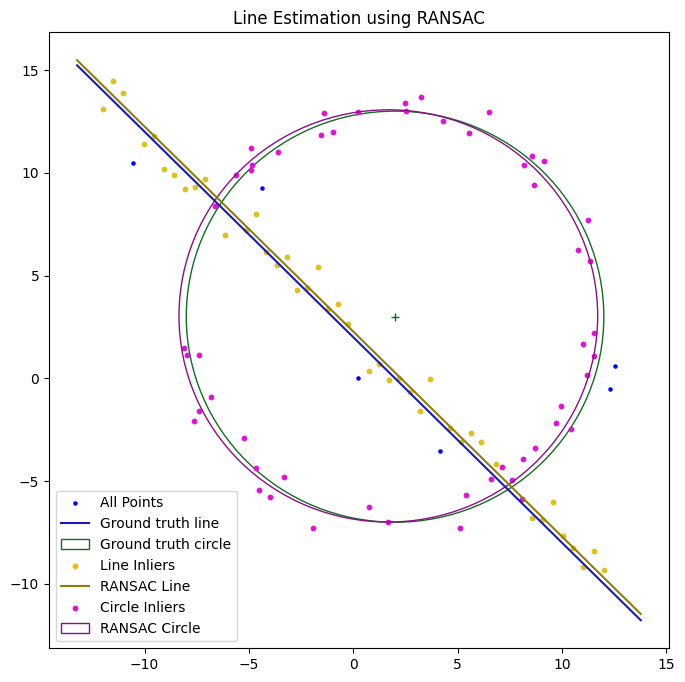

In [ ]:

# Define a function to calculate the distance between a point and a circle
def point_circle_distance(point, circle_params):
    x_center, y_center, r = circle_params
    x, y = point
    return abs(np.sqrt((x - x_center)**2 + (y - y_center)**2) - r)

# RANSAC parameters for estimating the circle
max_iterations_circle = 1000
min_inliers_circle = 20
radial_error_threshold_circle = 1

best_circle_params = None
best_circle_inliers = []

for _ in range(max_iterations_circle):
    # Randomly sample three points to define a circle
    sample_indices = np.random.choice(len(X), 3, replace=False)
    sample_points = X[sample_indices]

    # Calculate circle parameters (x_center, y_center, r) using the three points
    x1, y1 = sample_points[0]
    x2, y2 = sample_points[1]
    x3, y3 = sample_points[2]
    D = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    x_center = ((x1**2 + y1**2)*(y2-y3) + (x2**2 + y2**2)*(y3-y1) + (x3**2 + y3**2)*(y1-y2)) / D
    y_center = ((x1**2 + y1**2)*(x3-x2) + (x2**2 + y2**2)*(x1-x3) + (x3**2 + y3**2)*(x2-x1)) / D
    r = np.sqrt((x1-x_center)**2 + (y1-y_center)**2)

    # Count inliers based on the radial error threshold
    inliers = [i for i, point in enumerate(X) if point_circle_distance(point, (x_center, y_center, r)) < radial_error_threshold_circle]

    if len(inliers) >= min_inliers_circle:
        if len(inliers) > len(best_circle_inliers):
            best_circle_params = (x_center, y_center, r)
            best_circle_inliers = inliers

# Subtract the line inliers from all points to get the remnant points
remnant_points = np.delete(X, best_circle_inliers, axis=0)

# Define a function to calculate the distance between a point and a line
def point_line_distance(point, line_params):
    a, b, d = line_params
    x, y = point
    return abs(a*x + b*y + d) / np.sqrt(a*a + b*b)

# RANSAC parameters for estimating the line
max_iterations_line = 1000
min_inliers_line = 20
inlier_threshold_line = 1

best_line_params = None
best_line_inliers = []

for _ in range(max_iterations_line):
    # Randomly sample two points to define a line
    sample_indices = np.random.choice(len(remnant_points), 2, replace=False)
    sample_points = remnant_points[sample_indices]

    # Calculate line parameters (a, b, d) using the two points
    x1, y1 = sample_points[0]
    x2, y2 = sample_points[1]
    a = y2 - y1
    b = x1 - x2
    d = x2*y1 - x1*y2
    norm = np.sqrt(a*a + b*b)
    a /= norm
    b /= norm
    d /= norm

    # Count inliers based on the distance threshold
    inliers = [i for i, point in enumerate(remnant_points) if point_line_distance(point, (a, b, d)) < inlier_threshold_line]

    if len(inliers) >= min_inliers_line:
        if len(inliers) > len(best_line_inliers):
            best_line_params = (a, b, d)
            best_line_inliers = inliers

# Plot the line and inliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# All points
ax.scatter(X[:, 0], X[:, 1], label='All Points', color='b', s=5)

# Ground truth line
x_ = np.array([x_min, x_max])
y_ = m_init * x_ + b_init
plt.plot(x_, y_, color = '#171BBC', label = 'Ground truth line')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r_init, color = '#106E20', fill = False, label = 'Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color = '#106E20')

# Line inliers
ax.scatter(remnant_points[best_line_inliers, 0], remnant_points[best_line_inliers, 1], label='Line Inliers', color='#DDC21B', s=10)

# RANSAC line
x_range = np.linspace(x_min, x_max, 100)
y_range = (-best_line_params[0] * x_range - best_line_params[2]) / best_line_params[1]
plt.plot(x_range, y_range, color='#907E0C', label='RANSAC Line')

# Circle inliers
ax.scatter(X[best_circle_inliers, 0], X[best_circle_inliers, 1], label='Circle Inliers', color='#DF15D1', s=10)

# RANSAC circle
circle = plt.Circle((best_circle_params[0], best_circle_params[1]), best_circle_params[2], color='#900C87', fill=False, label='RANSAC Circle')
ax.add_patch(circle)

plt.legend()
plt.title('Line Estimation using RANSAC')
plt.show()